# Mini geocoding system
By: Nur Rochman Muhammad

### Objective:
My objective only to prove my couriousity about geocoding.

This way of thinking could be used for someone who need to reduce paid geocoding services by reuse their geocoding history or someone has big data address and lat/long pairs.

### How it works

We input address keyword, then we get a result hexagon, point, and heatmap that (indicate confidence level of address we are looking for)

### Dataset
I used reverse geocoding service from nonatim/ osm (free).

#### My idea is to creating / replicate geocoding (pair of address and coordinate) to create small geocoding system based on historical geocoding from osm services.

1st step: I define test area,(DKI Jakarta), then resample that area into point grid.

2nd. step: Do geocoding process of grid latlong.

3rd. step: grouping those points by hexagon and labelling each group of points using hexagon id.

4th step: build matching keyword system for our address library to find which hexagon contained our address/location that we try to find.

# 1st step I used QGIS to define area and make points grid

# 2.nd step loading and do reverse geocoding process for point grid

In [1]:
import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

C:\Users\Lenovo\anaconda3\envs\wallaby\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Lenovo\anaconda3\envs\wallaby\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Lenovo\anaconda3\envs\wallaby\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %
<ipython-input-1-2e86d64e375d>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
locator = Nominatim(user_agent="myGeocoder")

In [3]:
coordinates = "0.543544, 123.056769"
location = locator.reverse(coordinates)
location.raw

{'place_id': 164058077,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 331040340,
 'lat': '0.5435360025916869',
 'lon': '123.05686608770816',
 'display_name': 'Jalan Diponegoro, Gorontalo, 96114, Indonesia',
 'address': {'road': 'Jalan Diponegoro',
  'city': 'Gorontalo',
  'state': 'Gorontalo',
  'postcode': '96114',
  'country': 'Indonesia',
  'country_code': 'id'},
 'boundingbox': ['0.5380188', '0.5438043', '123.056182', '123.0568907']}

In [4]:
locator.geocode("BOGOR")

Location(Bogor, Jawa Barat, 16121, Indonesia, (-6.5962986, 106.7972421, 0.0))

In [5]:
print(location.address)


Jalan Diponegoro, Gorontalo, 96114, Indonesia


### a. loading shp points grid

In [6]:
import geopandas as gpd
import os

### we will use reverse geocode to all this latlong grid 

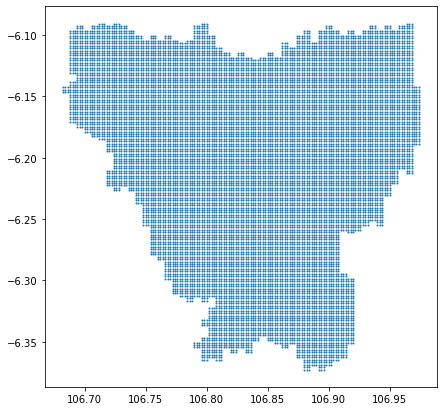

In [7]:
SHAPEFILE_PATH = os.path.join('latlong.shp')
df_map_id = gpd.read_file(SHAPEFILE_PATH)

df_map_id.plot(markersize=1,figsize=(15, 7))

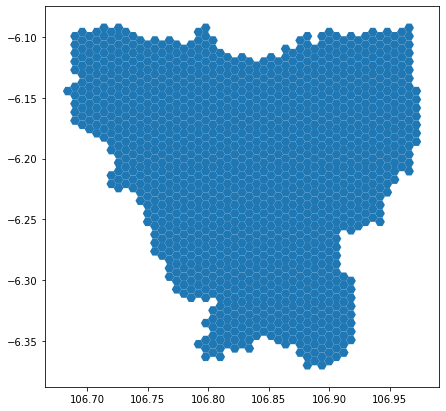

In [8]:
HEX = gpd.read_file(os.path.join('HEX.shp'))

HEX.plot(figsize=(15, 7))

In [9]:
df_map_id['geom'] = df_map_id.geometry.y.map(str) + ',' + df_map_id.geometry.x.map(str)

### b. reverse geocoding process (be patient)

Reverse geocoding using openstreetmap (free) to make address and lat/long pairs.

In [10]:
locator = Nominatim(user_agent='myGeocoder', timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [11]:
from tqdm._tqdm_notebook import tqdm_notebook

In [12]:
tqdm_notebook.pandas()
df_map_id['address'] = df_map_id['geom'].progress_apply(rgeocode)

C:\Users\Lenovo\anaconda3\envs\wallaby\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Imagine this is your company history that using paid geocoding services, and your geocoding history already cover all area.

In [18]:
df_map_id['alamat']=df_map_id.address.apply(lambda x: x.address)

# 4th Create tf-idf seach engine, and create some viz

I use tfidf vectorizer to build this seach engine based on address list

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_map_id['alamat'])

join base points maps with hexagon maps id

In [21]:
gpd_map_id_hex = gpd.sjoin(df_map_id, HEX, how="left", op='intersects') 

# Visualize your key word

Here you know that I am a noob in python

In [22]:
import folium
from folium.plugins import HeatMap
        
def mini_geocode(gpd_map_id_hex,X,keyword):
        query_vec = vectorizer.transform([keyword]) # Put your key word here
        results = cosine_similarity(X,query_vec).reshape((-1,))
        ls_score=[]
        ls_ID=[]
        ls_address=[]
        ls_lat=[]
        ls_long=[]
        for i in results.argsort()[-10:][::-1]:
            ls_score.append(results[i])
            ls_ID.append(gpd_map_id_hex.iloc[i].ID)
            ls_address.append(gpd_map_id_hex.iloc[i].alamat)
            ls_lat.append(gpd_map_id_hex.iloc[i].geometry.y)
            ls_long.append(gpd_map_id_hex.iloc[i].geometry.x)
        ky=pd.DataFrame(zip(ls_score,ls_ID,ls_address,ls_lat,ls_long)).rename(columns={0:'score',1:'ID',2:'address',3:'lat',4:'long'})
        ky=ky.query('score>0.6') # cut threshold score

        # Plot simple maps
        fig, ax = plt.subplots()
        HEX.plot(ax=ax, facecolor='gray');
        HEX[HEX.ID.isin(ky.ID)].plot(ax=ax, facecolor='red');

        m = folium.Map([HEX[HEX.ID.isin(ky.ID)].iloc[0].bottom,HEX[HEX.ID.isin(ky.ID)].iloc[0].left], zoom_start=15, tiles='cartodbpositron')
        folium.GeoJson(HEX[HEX.ID.isin(ky.ID)]).add_to(m)
        for lat, lon, address in zip(ky.lat,
                                     ky.long,
                                     ky.address):
            folium.Circle(
                [lat, lon],
                radius=10,
                threshold_scale=[0,1,2,3],
                fill_color='blue',
                fill=True,
                fill_opacity=0.4
                ).add_child(folium.Popup(f'address:{address}')).add_to(m)
            
        HeatMap(list(zip(ky.lat,ky.long,ky["score"])),min_opacity=0.1,max_val=ky["score"].max(),radius=50, blur=100,max_zoom=1).add_to(m)
        return m

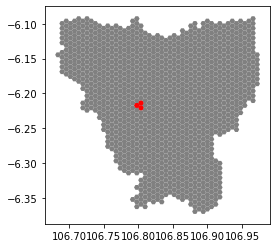

In [23]:
mini_geocode(gpd_map_id_hex,X,"gelora bung karno")

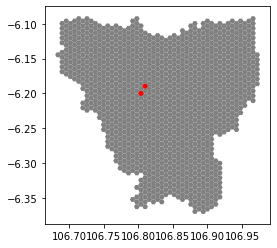

In [24]:
mini_geocode(gpd_map_id_hex,X,"Jalan Petamburan")

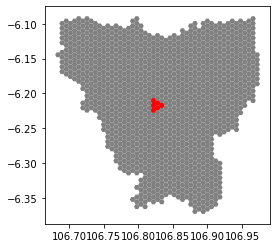

In [25]:
mini_geocode(gpd_map_id_hex,X,"karet kuningan setiabudi")

# Improvement

1. use denser dataset to produce more accurate geocoding system replica.
2. Pull all POI not only use grid address, because sometimes geocoding more accurate for POI/specifict place name.
3. Use fuzzywuzzy for 2nd layer filter mathcing result to give better similarity scoring.